## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from scipy.stats import spearmanr
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
import transformers

from radam import RAdam
from text_data import BertDataset
from xlnet import CustomXLNet
from learning import Learner
from lr_finder import LRFinder
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed
from utils.torch import to_cpu

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [4]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [5]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [6]:
num_workers = 10
bs = 2

## Training model

In [7]:
lr = 1e-5
device = 'cuda'
n_epochs = 5
grad_accum = 1
weight_decay = 0.1
model_output_dir = 'xlnet_2_output/'
pretrained_model = 'siamese_xlnet_2'
model_name = 'siamese_xlnet_2_head'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10
loss_fn = nn.BCEWithLogitsLoss()

In [8]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(get_optimizer_param_groups(model, lr, weight_decay))

def get_model(fold_id):
    checkpoint_file = f'{checkpoint_dir}{pretrained_model}_fold_{fold_id+1}_best.pth'
    model = CustomXLNet(256, cat_features_train.shape[1], head_dropout=0.5)
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model.head

Fold 1 started at Tue Feb  4 22:39:45 2020


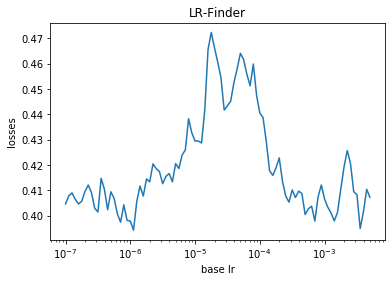

epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45122 - spearmanr 0.4206
best model: epoch -1 - 0.4206
epoch 0: 	 Start training...


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



epoch 0/5 	 train : loss 0.42018 - spearmanr 0.49177
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44922 - spearmanr 0.42088
best model: epoch 0 - 0.42088
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41864 - spearmanr 0.49477
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44904 - spearmanr 0.42133
best model: epoch 1 - 0.42133
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41809 - spearmanr 0.49577
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44886 - spearmanr 0.42166
best model: epoch 2 - 0.42166
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41718 - spearmanr 0.49846
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44909 - spearmanr 0.42171
best model: epoch 3 - 0.42171
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41635 - spearmanr 0.50032
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44903 - spearmanr 0.42191
best model: epoch 4 - 0.42191
TRAINING END: Best score achieved on epoch 4 - 0.42191
Starting inference for model: checkpoints/siamese_xlnet_2_head_fold_1_best.pth



Fold 2 started at Tue Feb  4 22:41:51 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45233 - spearmanr 0.42783
best model: epoch -1 - 0.42783
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41984 - spearmanr 0.49043
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44971 - spearmanr 0.42851
best model: epoch 0 - 0.42851
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41878 - spearmanr 0.4913
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44954 - spearmanr 0.42885
best model: epoch 1 - 0.42885
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41723 - spearmanr 0.4956
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44944 - spearmanr 0.42911
best model: epoch 2 - 0.42911
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41757 - spearmanr 0.49533
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44948 - spearmanr 0.42921
best model: epoch 3 - 0.42921
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41669 - spearmanr 0.49699
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44956 - spearmanr 0.42933
best model: epoch 4 - 0.42933
TRAINING END: Best score achieved on epoch 4 - 0.42933
Starting inference for model: checkpoints/siamese_xlnet_2_head_fold_2_best.pth



Fold 3 started at Tue Feb  4 22:43:52 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45495 - spearmanr 0.41419
best model: epoch -1 - 0.41419
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41868 - spearmanr 0.49442
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45185 - spearmanr 0.41443
best model: epoch 0 - 0.41443
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41737 - spearmanr 0.49698
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45173 - spearmanr 0.41427
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41673 - spearmanr 0.49866
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45185 - spearmanr 0.41407
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.4162 - spearmanr 0.49989
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45193 - spearmanr 0.41342
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41554 - spearmanr 0.50167
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45207 - spearmanr 0.41347
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.41443
Starting inference for model: checkpoints/siamese_xlnet_2_head_fold_3_best.pth



Fold 4 started at Tue Feb  4 22:45:55 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45302 - spearmanr 0.40542
best model: epoch -1 - 0.40542
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.42119 - spearmanr 0.4882
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45106 - spearmanr 0.40604
best model: epoch 0 - 0.40604
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.42021 - spearmanr 0.49044
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45069 - spearmanr 0.40651
best model: epoch 1 - 0.40651
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.4195 - spearmanr 0.49136
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45054 - spearmanr 0.4066
best model: epoch 2 - 0.4066
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41816 - spearmanr 0.49583
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45063 - spearmanr 0.40636
model not improved for 1 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41843 - spearmanr 0.49515
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45073 - spearmanr 0.40622
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40660
Starting inference for model: checkpoints/siamese_xlnet_2_head_fold_4_best.pth



Fold 5 started at Tue Feb  4 22:47:59 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45009 - spearmanr 0.40483
best model: epoch -1 - 0.40483
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.42523 - spearmanr 0.47954
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.4481 - spearmanr 0.40636
best model: epoch 0 - 0.40636
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.4232 - spearmanr 0.48435
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44818 - spearmanr 0.40665
best model: epoch 1 - 0.40665
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.42188 - spearmanr 0.48719
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44833 - spearmanr 0.40703
best model: epoch 2 - 0.40703
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.42123 - spearmanr 0.48838
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44847 - spearmanr 0.40725
best model: epoch 3 - 0.40725
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.42065 - spearmanr 0.48997
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.4485 - spearmanr 0.40696
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 3 - 0.40725
Starting inference for model: checkpoints/siamese_xlnet_2_head_fold_5_best.pth



Fold 6 started at Tue Feb  4 22:50:02 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.44999 - spearmanr 0.3923
best model: epoch -1 - 0.3923
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.42073 - spearmanr 0.49158
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44854 - spearmanr 0.39322
best model: epoch 0 - 0.39322
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.4189 - spearmanr 0.49654
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44871 - spearmanr 0.39365
best model: epoch 1 - 0.39365
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41871 - spearmanr 0.49711
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44889 - spearmanr 0.39345
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41732 - spearmanr 0.5003
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44922 - spearmanr 0.39328
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41666 - spearmanr 0.50104
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44932 - spearmanr 0.39299
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 1 - 0.39365
Starting inference for model: checkpoints/siamese_xlnet_2_head_fold_6_best.pth



Fold 7 started at Tue Feb  4 22:52:05 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45554 - spearmanr 0.41855
best model: epoch -1 - 0.41855
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.42099 - spearmanr 0.48897
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45267 - spearmanr 0.41932
best model: epoch 0 - 0.41932
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.4196 - spearmanr 0.49201
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45226 - spearmanr 0.41976
best model: epoch 1 - 0.41976
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41864 - spearmanr 0.49427
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45226 - spearmanr 0.42027
best model: epoch 2 - 0.42027
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.4179 - spearmanr 0.49685
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45223 - spearmanr 0.42065
best model: epoch 3 - 0.42065
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41762 - spearmanr 0.49588
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45236 - spearmanr 0.42072
best model: epoch 4 - 0.42072
TRAINING END: Best score achieved on epoch 4 - 0.42072
Starting inference for model: checkpoints/siamese_xlnet_2_head_fold_7_best.pth



Fold 8 started at Tue Feb  4 22:54:05 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.46006 - spearmanr 0.41961
best model: epoch -1 - 0.41961
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41935 - spearmanr 0.49086
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45718 - spearmanr 0.42061
best model: epoch 0 - 0.42061
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41824 - spearmanr 0.49279
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45689 - spearmanr 0.42099
best model: epoch 1 - 0.42099
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41707 - spearmanr 0.49591
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45695 - spearmanr 0.42103
best model: epoch 2 - 0.42103
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41553 - spearmanr 0.49822
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45709 - spearmanr 0.42112
best model: epoch 3 - 0.42112
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41532 - spearmanr 0.49908
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45709 - spearmanr 0.42117
best model: epoch 4 - 0.42117
TRAINING END: Best score achieved on epoch 4 - 0.42117
Starting inference for model: checkpoints/siamese_xlnet_2_head_fold_8_best.pth



Fold 9 started at Tue Feb  4 22:56:08 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.4508 - spearmanr 0.41213
best model: epoch -1 - 0.41213
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.41915 - spearmanr 0.49348
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44855 - spearmanr 0.41311
best model: epoch 0 - 0.41311
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41778 - spearmanr 0.49661
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44852 - spearmanr 0.41326
best model: epoch 1 - 0.41326
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41707 - spearmanr 0.49834
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44842 - spearmanr 0.41348
best model: epoch 2 - 0.41348
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.4169 - spearmanr 0.49904
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44864 - spearmanr 0.41361
best model: epoch 3 - 0.41361
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41586 - spearmanr 0.50119
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44866 - spearmanr 0.41371
best model: epoch 4 - 0.41371
TRAINING END: Best score achieved on epoch 4 - 0.41371
Starting inference for model: checkpoints/siamese_xlnet_2_head_fold_9_best.pth



Fold 10 started at Tue Feb  4 22:58:12 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.44301 - spearmanr 0.42449
best model: epoch -1 - 0.42449
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.42047 - spearmanr 0.49165
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44098 - spearmanr 0.42575
best model: epoch 0 - 0.42575
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.41969 - spearmanr 0.49422
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44069 - spearmanr 0.42655
best model: epoch 1 - 0.42655
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.41872 - spearmanr 0.49607
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44074 - spearmanr 0.42653
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.41776 - spearmanr 0.49761
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44081 - spearmanr 0.42675
best model: epoch 3 - 0.42675
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.41691 - spearmanr 0.50025
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44085 - spearmanr 0.42667
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 3 - 0.42675
Starting inference for model: checkpoints/siamese_xlnet_2_head_fold_10_best.pth



OOF score: 0.4160958987205498


In [9]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    
    output_file_path = lambda mode: f'{model_output_dir}{mode}_{pretrained_model}_fold_{fold_id+1}'
    train_loader = DataLoader(
        BertDataset(cat_features_train, np.load(f"{output_file_path('train')}_q_outputs.npy"),
                    np.load(f"{output_file_path('train')}_a_outputs.npy"), train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        BertDataset(cat_features_train, np.load(f"{output_file_path('valid')}_q_outputs.npy"),
                    np.load(f"{output_file_path('valid')}_a_outputs.npy"), valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = get_model(fold_id)
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-7, 
                             end_lr=1e-2, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=optim.lr_scheduler.StepLR(optimizer, n_epochs, 0.5), 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=False,
        eval_at_start=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [10]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 8 0.48759232351656245
5 4 0.4648507670444162
9 32 0.12845325534535335
11 8 0.758910903492332
12 4 0.5503693998979307
13 4 0.3135152884734173
14 4 0.642276855011164
15 8 0.590852812493358
19 64 0.14044948496057003
23 16 0.1489272481791355


In [11]:
np.array(opt_ds), np.array(opt_indices)

(array([ 8,  4, 32,  8,  4,  4,  4,  8, 64, 16]),
 array([ 2,  5,  9, 11, 12, 13, 14, 15, 19, 23]))

In [12]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [13]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.416096
CV unique rows,0.380556
CV ignoring hard targets,0.440298
CV unique rows ignoring hard targets,0.402393
CV w rounding,0.447620
CV unique rows w rounding,0.430326
CV ignoring hard targets w rounding,0.469989
CV unique rows ignoring hard targets w rounding,0.443206


In [14]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.420012
CV unique rows,0.384685
CV ignoring hard targets,0.440298
CV unique rows ignoring hard targets,0.402393
CV w rounding,0.449150
CV unique rows w rounding,0.430326
CV ignoring hard targets w rounding,0.469989
CV unique rows ignoring hard targets w rounding,0.443206


In [15]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [16]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
1,46,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
2,70,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
3,132,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
4,200,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001


In [17]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [18]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.821893,0.631839,0.235900,0.641818,0.602212,0.416144,0.633482,0.595162,0.113910,0.009498,0.593455,0.127750,0.330722,0.047538,0.030840,0.215652,0.163943,0.127828,0.445187,0.002672,0.746272,0.889019,0.569963,0.951194,0.939363,0.732597,0.110206,0.105199,0.811110,0.701762
1,0.823346,0.613689,0.023556,0.586123,0.918177,0.713154,0.553694,0.678460,0.495898,0.001004,0.271873,0.114503,0.786473,0.004679,0.707389,0.030484,0.099272,0.088714,0.364932,0.006126,0.715766,0.475653,0.247999,0.735652,0.745255,0.302841,0.020818,0.031772,0.454955,0.758368
2,0.565489,0.301808,0.005148,0.697030,0.772619,0.872592,0.389313,0.214020,0.096960,0.003323,0.377125,0.151336,0.002040,0.001005,0.000967,0.215936,0.734544,0.233255,0.156845,0.000069,0.504837,0.849880,0.608707,0.905958,0.918765,0.664809,0.714353,0.289525,0.445894,0.767770
3,0.820851,0.684406,0.044748,0.861295,0.830458,0.914255,0.586692,0.619783,0.292009,0.001147,0.189904,0.964403,0.015604,0.013181,0.062431,0.018629,0.052242,0.087393,0.344722,0.001381,0.722060,0.855698,0.732204,0.903795,0.918394,0.764786,0.038044,0.084739,0.863084,0.640506
4,0.765967,0.801088,0.004616,0.671230,0.767414,0.884138,0.496483,0.418829,0.197543,0.000705,0.365777,0.441534,0.001749,0.000627,0.000610,0.003937,0.879921,0.306053,0.100760,0.000031,0.792631,0.761462,0.445234,0.852934,0.871553,0.564388,0.893489,0.253540,0.049680,0.610702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.848111,0.581138,0.203067,0.752026,0.686352,0.687393,0.661886,0.628899,0.582115,0.002535,0.509439,0.930688,0.138302,0.348233,0.007382,0.099952,0.013362,0.033952,0.729488,0.002119,0.736928,0.893108,0.722298,0.944674,0.919625,0.728559,0.094776,0.087455,0.910592,0.739647
6075,0.813566,0.333190,0.071515,0.517573,0.542612,0.396373,0.726927,0.714694,0.071882,0.002729,0.727500,0.014036,0.008290,0.004594,0.001461,0.014681,0.804700,0.401893,0.228192,0.000083,0.661143,0.837075,0.588126,0.912285,0.917383,0.625990,0.855865,0.372010,0.225992,0.843084
6076,0.612201,0.387870,0.008691,0.669278,0.713810,0.875085,0.436252,0.320881,0.181803,0.002715,0.466250,0.708927,0.004875,0.001808,0.000710,0.009979,0.805153,0.346062,0.163383,0.000093,0.525100,0.598352,0.432606,0.809449,0.781612,0.419028,0.657840,0.212188,0.549205,0.488965
6077,0.822156,0.684396,0.809414,0.233093,0.228940,0.077111,0.612737,0.724480,0.612393,0.002240,0.933838,0.703557,0.128570,0.068383,0.006381,0.021131,0.011263,0.159910,0.695702,0.000253,0.881761,0.733082,0.639248,0.799506,0.856007,0.590866,0.024003,0.151346,0.872319,0.828416


In [19]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.388847
question_body_critical                   0.620736
question_conversational                  0.421202
question_expect_short_answer             0.308676
question_fact_seeking                    0.367837
question_has_commonly_accepted_answer    0.434918
question_interestingness_others          0.364872
question_interestingness_self            0.512285
question_multi_intent                    0.589107
question_not_really_a_question           0.085652
question_opinion_seeking                 0.484827
question_type_choice                     0.743228
question_type_compare                    0.364292
question_type_consequence                0.192187
question_type_definition                 0.362774
question_type_entity                     0.460775
question_type_instructions               0.783351
question_type_procedure                  0.371225
question_type_reason_explanation         0.671745
question_type_spelling                   0.068869


In [20]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.068869,3.0
question_not_really_a_question,0.085652,5.0
answer_plausible,0.146585,9.0
answer_relevance,0.174770,9.0
question_type_consequence,0.192187,5.0
answer_well_written,0.231212,9.0
answer_helpful,0.246367,9.0
question_expect_short_answer,0.308676,5.0
answer_type_procedure,0.311802,5.0
answer_satisfaction,0.355057,17.0


In [21]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

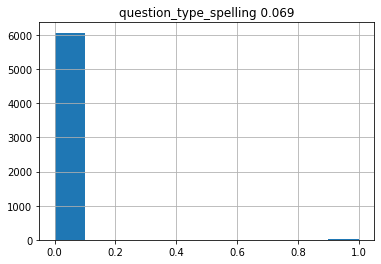

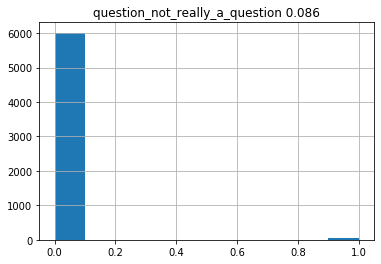

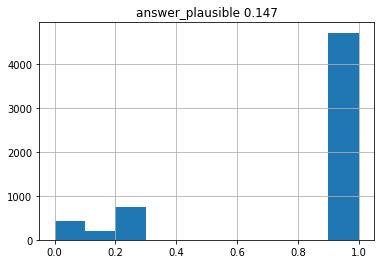

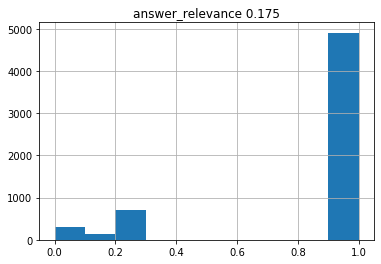

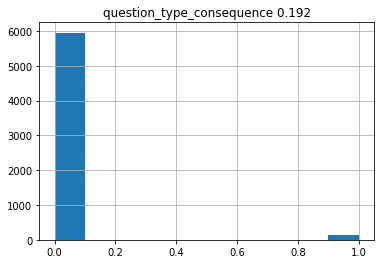

In [22]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


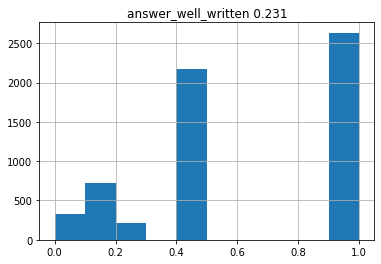

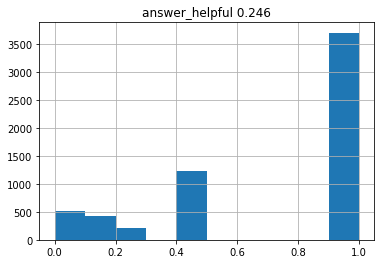

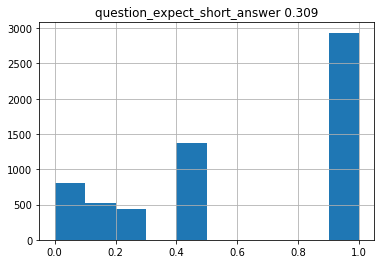

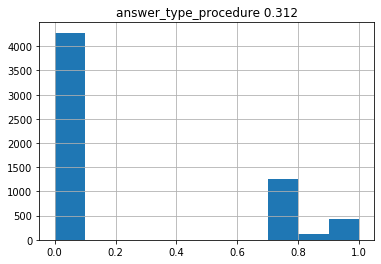

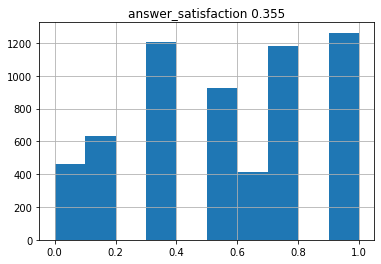

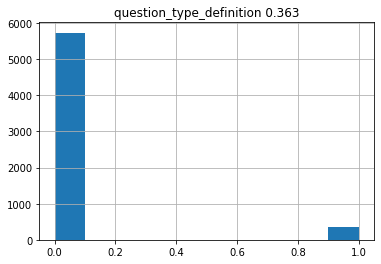

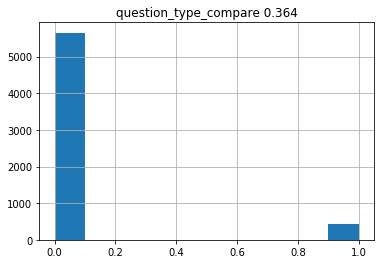

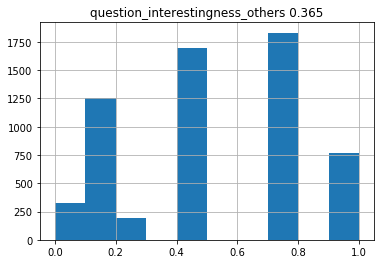

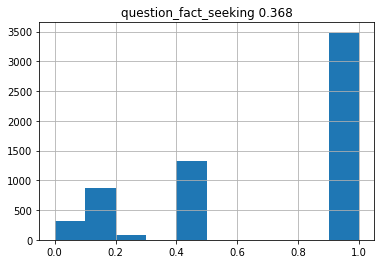

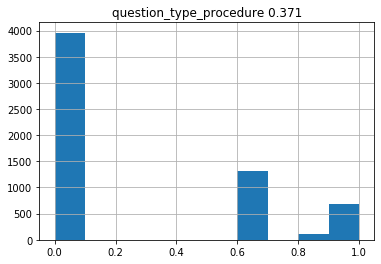

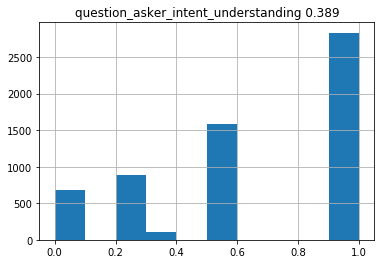

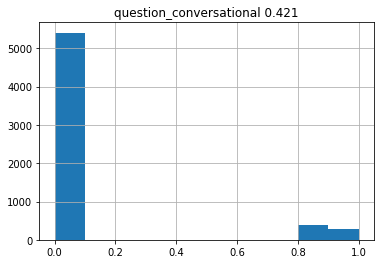

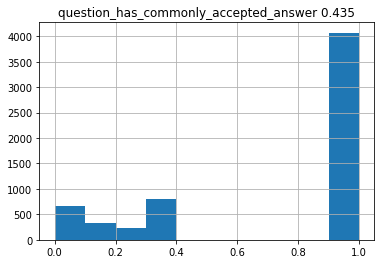

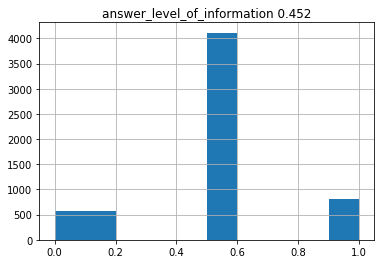

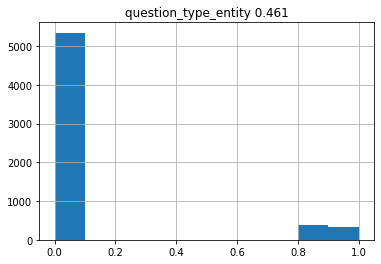

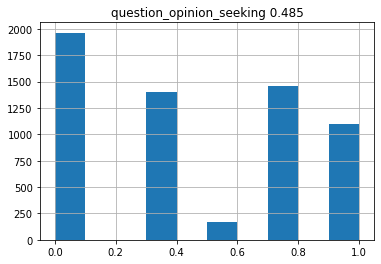

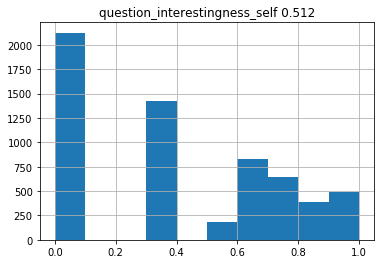

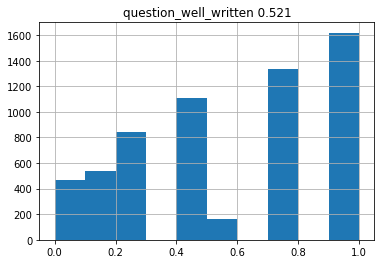

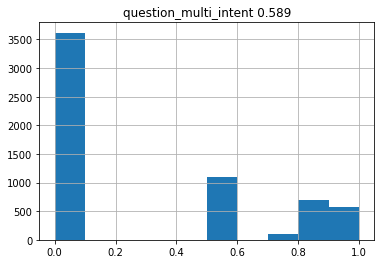

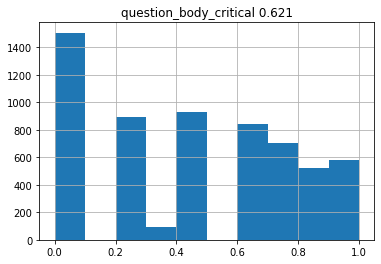

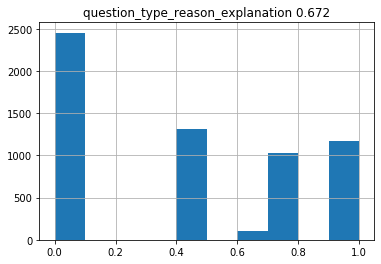

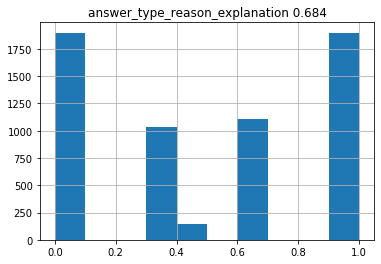

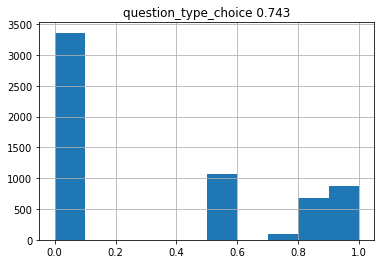

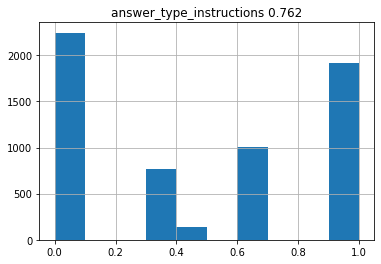

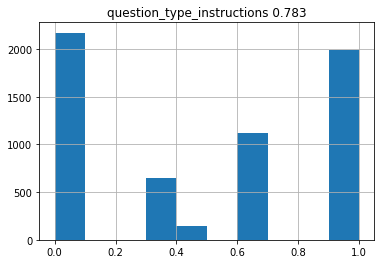

In [23]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')